<a href="https://colab.research.google.com/github/dbonafilia/SGDWR-AdamWR-Keras/blob/master/Main_Training_Stuff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
LR = 1e-4
EPOCHS = 1000
EPOCHS_PER_UPDATE = 2
RUNNAME = "TESTING_1e4_flood_3"

In [0]:
import torch
from torchvision import transforms
import torchvision.transforms.functional as F
import random

class InMemoryDataset(torch.utils.data.Dataset):
  
  def __init__(self, data_list, preprocess_func):
    self.data_list = data_list
    self.preprocess_func = preprocess_func
  
  def __getitem__(self, i):
    return self.preprocess_func(self.data_list[i])
  
  def __len__(self):
    return len(self.data_list)


def processAndAugment(data):
  (x,y) = data
  im,label = x.copy(), y.copy()

  # convert to PIL for easier transforms
  im1 = Image.fromarray(im[0])
  im2 = Image.fromarray(im[1])
  label = Image.fromarray(label.squeeze())
  #im1 = im[0]

  # Get params for random transforms
  i, j, h, w = transforms.RandomCrop.get_params(im1, (256, 256))
  
  im1 = F.crop(im1, i, j, h, w)
  im2 = F.crop(im2, i, j, h, w)
  label = F.crop(label, i, j, h, w)
  if random.random() > 0.5:
    im1 = F.hflip(im1)
    im2 = F.hflip(im2)
    label = F.hflip(label)
  if random.random() > 0.5:
    im1 = F.vflip(im1)
    im2 = F.vflip(im2)
    label = F.vflip(label)
  
  norm = transforms.Normalize([0.6851, 0.5235], [0.0820, 0.1102])
  im = torch.stack([transforms.ToTensor()(im1).squeeze(), transforms.ToTensor()(im2).squeeze()])
  label = transforms.ToTensor()(label).squeeze()
  if torch.sum(label.gt(.003) * label.lt(.004)):
    label *= 255
  label = label.round()

  return im, label


def processTestIm(data):
  (x,y) = data
  im,label = x.copy(), y.copy()
  norm = transforms.Normalize([0.6851, 0.5235], [0.0820, 0.1102])
  #label[0][0][0] = 255
  # convert to PIL for easier transforms
  im_c1 = Image.fromarray(im[0]).resize((512,512))
  im_c2 = Image.fromarray(im[1]).resize((512,512))
  label = Image.fromarray(label.squeeze()).resize((512,512))

  im_c1s = [F.crop(im_c1, 0, 0, 256, 256), F.crop(im_c1, 0, 256, 256, 256),
            F.crop(im_c1, 256, 0, 256, 256), F.crop(im_c1, 256, 256, 256, 256)]
  im_c2s = [F.crop(im_c2, 0, 0, 256, 256), F.crop(im_c2, 0, 256, 256, 256),
            F.crop(im_c2, 256, 0, 256, 256), F.crop(im_c2, 256, 256, 256, 256)]
  labels = [F.crop(label, 0, 0, 256, 256), F.crop(label, 0, 256, 256, 256),
            F.crop(label, 256, 0, 256, 256), F.crop(label, 256, 256, 256, 256)]


  ims = [torch.stack((transforms.ToTensor()(x).squeeze(),
                    transforms.ToTensor()(y).squeeze()))
                    for (x,y) in zip(im_c1s, im_c2s)]
  #ims = [norm(im) for im in ims]
  ims = torch.stack(ims)
  labels = [(transforms.ToTensor()(label).squeeze()) for label in labels]
  labels = torch.stack(labels)
  if torch.sum(labels.gt(.003) * labels.lt(.004)):
    labels *= 255
  labels = labels.round()
  return ims, labels


Read in Data

In [19]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [20]:
!pip install rasterio

In [0]:
import csv
from PIL import Image
import rasterio
import numpy as np
import os
BASEDIR = '/content/gdrive/My Drive/'

def getArr(fname):
  return rasterio.open(BASEDIR + fname).read()


def download_perm_water_data_from_file(fname):
  with open(fname) as f:
    data_fnames = [tuple(line) for line in csv.reader(f)]
  i = 0
  data = []
  for (x,y) in data_fnames:
    arr_x, arr_y = getArr(x), getArr(y)
    if np.sum((arr_x != arr_x)) == 0:
      ignore = (arr_y == -1)
      ignore = ((np.uint8(ignore) * -1) * 256) + 1
      arr_y *= ignore
      data.append((arr_x, arr_y))
      i+=1
      print(i)
    else:
      print("skipping nan")
  return data

def download_perm_train_data():
  TRAINING_DATA_FILE = BASEDIR + 'permanent_water_train_data.csv'
  return download_perm_water_data_from_file(TRAINING_DATA_FILE)

def download_perm_valid_data():
  VALID_DATA_FILE = BASEDIR + 'permanent_water_validation_data.csv'
  return download_perm_water_data_from_file(VALID_DATA_FILE)

def download_perm_test_data():
  TEST_DATA_FILE = BASEDIR + 'permanent_water_test_data.csv'
  return download_perm_water_data_from_file(TEST_DATA_FILE)


In [69]:
from google.colab import auth
auth.authenticate_user()

!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

!mkdir files4
!gcsfuse --implicit-dirs cnn_chips /content/files4



KeyboardInterrupt: ignored

In [0]:

def getArrFlood(fname):
  return rasterio.open(fname).read()

def download_flood_water_data_from_list(l):
  i= 0
  tot_nan = 0
  tot_good = 0
  flood_data = []
  for (im_fname, mask_fname) in l:
    if "Bolivia" in im_fname:
      continue
    arr_x = getArrFlood(os.path.join("/content/files4/", im_fname))
    #print(os.path.join("/content/files4/QC_v2/", mask_fname[3:]))
    arr_y = np.uint8(getArrFlood(os.path.join("/content/files4/QC_v2/", mask_fname[3:])))
    tot_nan += np.sum(arr_x != arr_x)
    tot_good += np.sum(arr_x == arr_x)
    if np.sum((arr_x != arr_x)) == 0:
      ignore = np.uint8((arr_y == -1))
      ignore = np.uint8(((np.uint8(ignore) * -1) * 256) + 1)
      arr_y *= ignore
      arr_x = np.clip(arr_x, -50, 1)
      arr_x = (arr_x + 50) / 51
      i += 1
      flood_data.append((arr_x,arr_y))
      print(i)
    else:
      print("skipping nan")
  print(tot_nan, tot_good)
  return flood_data

def load_flood_train_data():
  basedir = "/content/files4/"
  fname = "/content/files4/flood_train_data.csv"
  with open(fname) as f:
    fname = [tuple(line) for line in csv.reader(f)]
  return download_flood_water_data_from_list(fname)

def load_flood_valid_data():
  basedir = "/content/files4/"
  fname = "/content/files4/flood_valid_data.csv"
  with open(fname) as f:
    fname = [tuple(line) for line in csv.reader(f)]
  return download_flood_water_data_from_list(fname)

def load_flood_test_data():
  basedir = "/content/files4/"
  fname = "/content/files4/flood_test_data.csv"
  with open(fname) as f:
    fname = [tuple(line) for line in csv.reader(f)]
  return download_flood_water_data_from_list(fname)

In [23]:
ls /content/files4/QC/Bolivia_195474_QC.tif

ls: cannot access '/content/files4/QC/Bolivia_195474_QC.tif': No such file or directory


In [75]:
train_data = load_flood_train_data() #download_perm_train_data()
train_dataset = InMemoryDataset(train_data, processAndAugment)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, sampler=None,
                  batch_sampler=None, num_workers=0, collate_fn=None,
                  pin_memory=True, drop_last=False, timeout=0,
                  worker_init_fn=None)
train_iter = iter(train_loader)

/content/files4/QC_v2/Ghana_103272_QC.tif
1
/content/files4/QC_v2/Ghana_24858_QC.tif
2
/content/files4/QC_v2/Ghana_147015_QC.tif
3
/content/files4/QC_v2/Ghana_953791_QC.tif
4
/content/files4/QC_v2/Ghana_154838_QC.tif
5
/content/files4/QC_v2/Ghana_134751_QC.tif
skipping nan
/content/files4/QC_v2/Ghana_61925_QC.tif
6
/content/files4/QC_v2/Ghana_156478_QC.tif
7
/content/files4/QC_v2/Ghana_144050_QC.tif
8
/content/files4/QC_v2/Ghana_49890_QC.tif
9
/content/files4/QC_v2/Ghana_97516_QC.tif
10
/content/files4/QC_v2/Ghana_168875_QC.tif
11
/content/files4/QC_v2/Ghana_141910_QC.tif
12
/content/files4/QC_v2/Ghana_146222_QC.tif
13
/content/files4/QC_v2/Ghana_11745_QC.tif
14
/content/files4/QC_v2/Ghana_161233_QC.tif
skipping nan
/content/files4/QC_v2/Ghana_7496_QC.tif
15
/content/files4/QC_v2/Ghana_128663_QC.tif
skipping nan
/content/files4/QC_v2/Ghana_264787_QC.tif
16
/content/files4/QC_v2/Ghana_597288_QC.tif
17
/content/files4/QC_v2/Ghana_8090_QC.tif
18
/content/files4/QC_v2/Ghana_187318_QC.tif
1

In [76]:
valid_data = load_flood_valid_data() #download_perm_valid_data()
valid_dataset = InMemoryDataset(valid_data, processTestIm)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=4, shuffle=True, sampler=None,
                  batch_sampler=None, num_workers=0, collate_fn=lambda x: (torch.cat([a[0] for a in x], 0), torch.cat([a[1] for a in x], 0)),
                  pin_memory=True, drop_last=False, timeout=0,
                  worker_init_fn=None)
valid_iter = iter(train_loader)

/content/files4/QC_v2/Ghana_5079_QC.tif
1
/content/files4/QC_v2/Ghana_895194_QC.tif
2
/content/files4/QC_v2/Ghana_868803_QC.tif
3
/content/files4/QC_v2/Ghana_142312_QC.tif
4
/content/files4/QC_v2/Ghana_234935_QC.tif
skipping nan
/content/files4/QC_v2/Ghana_132163_QC.tif
5
/content/files4/QC_v2/Ghana_495107_QC.tif
6
/content/files4/QC_v2/Ghana_124834_QC.tif
7
/content/files4/QC_v2/Ghana_1033830_QC.tif
8
/content/files4/QC_v2/Ghana_277_QC.tif
9
/content/files4/QC_v2/Ghana_308249_QC.tif
10
/content/files4/QC_v2/India_1050276_QC.tif
11
/content/files4/QC_v2/India_764946_QC.tif
12
/content/files4/QC_v2/India_118868_QC.tif
skipping nan
/content/files4/QC_v2/India_533192_QC.tif
skipping nan
/content/files4/QC_v2/India_180633_QC.tif
13
/content/files4/QC_v2/India_244057_QC.tif
14
/content/files4/QC_v2/India_691027_QC.tif
15
/content/files4/QC_v2/India_769408_QC.tif
16
/content/files4/QC_v2/India_1018317_QC.tif
17
/content/files4/QC_v2/India_869358_QC.tif
18
/content/files4/QC_v2/India_164336_Q

In [73]:
test_data = load_flood_test_data()
test_dataset = InMemoryDataset(test_data, processTestIm)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True, sampler=None,
                  batch_sampler=None, num_workers=0, collate_fn=lambda x: x[0],
                  pin_memory=True, drop_last=False, timeout=0,
                  worker_init_fn=None)
test_iter = iter(train_loader)

/content/files4/QC_v2/Ghana_313799_QC.tif
1
/content/files4/QC_v2/Ghana_1078550_QC.tif
2
/content/files4/QC_v2/Ghana_97059_QC.tif
3
/content/files4/QC_v2/Ghana_359826_QC.tif
4
/content/files4/QC_v2/Ghana_319168_QC.tif
5
/content/files4/QC_v2/Ghana_866994_QC.tif
6
/content/files4/QC_v2/Ghana_406026_QC.tif
7
/content/files4/QC_v2/Ghana_53713_QC.tif
8
/content/files4/QC_v2/Ghana_83483_QC.tif
9
/content/files4/QC_v2/Ghana_167233_QC.tif
10
/content/files4/QC_v2/Ghana_141271_QC.tif
11
/content/files4/QC_v2/India_900498_QC.tif
12
/content/files4/QC_v2/India_591317_QC.tif
13
/content/files4/QC_v2/India_747992_QC.tif
14
/content/files4/QC_v2/India_79637_QC.tif
15
/content/files4/QC_v2/India_952728_QC.tif
16
/content/files4/QC_v2/India_828067_QC.tif
17
/content/files4/QC_v2/India_570384_QC.tif
18
/content/files4/QC_v2/India_44475_QC.tif
19
/content/files4/QC_v2/India_80221_QC.tif
20
/content/files4/QC_v2/India_1018327_QC.tif
21
/content/files4/QC_v2/India_592446_QC.tif
22
/content/files4/QC_v2/I

Set up net/parameters

In [31]:
import torchvision.models as models
import torch.nn as nn


net = models.segmentation.fcn_resnet50(pretrained=False, num_classes=2, pretrained_backbone=False)
net.backbone.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1,10]).float().cuda(),ignore_index=255)
optimizer = torch.optim.AdamW(net.parameters(),lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 10, T_mult=2, eta_min=0, last_epoch=-1)
def convertBNtoGN(module, num_groups=16):
  if isinstance(module, torch.nn.modules.batchnorm.BatchNorm2d):
    return nn.GroupNorm(num_groups, module.num_features,
                        eps=module.eps, affine=module.affine)
    if module.affine:
        mod.weight.data = module.weight.data.clone().detach()
        mod.bias.data = module.bias.data.clone().detach()

  for name, child in module.named_children():
      module.add_module(name, convertBNtoGN(child, num_groups=num_groups))

  return module

net = convertBNtoGN(net)
net

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): GroupNorm(16, 64, eps=1e-05, affine=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): GroupNorm(16, 64, eps=1e-05, affine=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): GroupNorm(16, 64, eps=1e-05, affine=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): GroupNorm(16, 256, eps=1e-05, affine=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): GroupNorm(16, 256, eps=1e-05, affine=True)
        )
  

In [43]:
torch.load("/content/gdrive/My Drive/TESTING_1e4_flood_2_478_0.5804364085197449.cp")

{}

Utility Functions

In [0]:
def computeIOU(output, target):
  output = torch.argmax(output, dim=1).flatten() 
  target = target.flatten()
  no_ignore = target.ne(255).cuda()
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  intersection = torch.sum(output * target)
  union = torch.sum(target) + torch.sum(output) - intersection
  return (intersection + .0000001) / (union + .0000001)
  

def computeAccuracy(output, target):
  output = torch.argmax(output, dim=1).flatten() 
  target = target.flatten()
  no_ignore = target.ne(255).cuda()
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  correct = torch.sum(output.eq(target))
  return correct.float() / len(target)


In [48]:
test_1 = torch.ones(2, 2, 256, 256)
test_2 = torch.zeros(2, 256, 256)
test_3 = torch.ones(2, 256, 256)


print(computeIOU(test_1.cuda(), test_2.cuda()))
print(computeIOU(test_1.cuda(), test_3.cuda()))

tensor(7.6294e-13, device='cuda:0')
tensor(1., device='cuda:0')


Train/Validation functions

In [0]:

training_losses = []
training_accuracies = []
training_ious = []
valid_losses = []
valid_accuracies = []
valid_ious = []

def train(inputs, labels, net, optimizer, scheduler):
  global running_loss
  global running_iou
  global running_count
  global running_accuracy
  # zero the parameter gradients
  optimizer.zero_grad()
  net = net.cuda()
  # forward + backward + optimize
  outputs = net(inputs.cuda())
  loss = criterion(outputs["out"], labels.long().cuda())
  loss.backward()
  optimizer.step()
  scheduler.step()

  running_loss += loss
  running_iou += computeIOU(outputs["out"], labels.cuda())
  running_accuracy += computeAccuracy(outputs["out"], labels.cuda())
  running_count += 1

def validation_loop(validation_data_loader, net):
  global running_loss
  global running_iou
  global running_count
  global running_accuracy
  global max_valid_iou

  global training_losses
  global training_accuracies
  global training_ious
  global valid_losses
  global valid_accuracies
  global valid_ious

  net = net.eval()
  net = net.cuda()
  count = 0
  iou = 0
  loss = 0
  accuracy = 0
  with torch.no_grad():
      for (images, labels) in validation_data_loader:
          net = net.cuda()
          outputs = net(images.cuda())
          valid_loss = criterion(outputs["out"], labels.long().cuda())
          valid_iou = computeIOU(outputs["out"], labels.cuda())
          valid_accuracy = computeAccuracy(outputs["out"], labels.cuda())
          iou += valid_iou
          loss += valid_loss
          accuracy += valid_accuracy
          count += 1

  iou = iou / count
  accuracy = accuracy / count

  if iou > max_valid_iou:
    max_valid_iou = iou
    save_path = os.path.join(BASEDIR, "{}_{}_{}.cp".format(RUNNAME, i, iou.item()))
    torch.save(net.state_dict(), save_path)
    print("model saved at", save_path)

  loss = loss / count
  print("Training Loss:", running_loss / running_count)
  print("Training IOU:", running_iou / running_count)
  print("Training Accuracy:", running_accuracy / running_count)
  print("Validation Loss:", loss)
  print("Validation IOU:", iou)
  print("Validation Accuracy:", accuracy)


  training_losses.append(running_loss / running_count)
  training_accuracies.append(running_accuracy / running_count)
  training_ious.append(running_iou / running_count)
  valid_losses.append(loss)
  valid_accuracies.append(accuracy)
  valid_ious.append(iou)


Train Loop

In [0]:
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output

running_loss = 0
running_iou = 0
running_count = 0
running_accuracy = 0

training_losses = []
training_accuracies = []
training_ious = []
valid_losses = []
valid_accuracies = []
valid_ious = []


def train_epoch(net, optimizer, scheduler, train_iter):
  for (inputs, labels) in tqdm(train_iter):
    train(inputs.cuda(), labels.cuda(), net.cuda(), optimizer, scheduler)
 

def train_validation_loop(net, optimizer, scheduler, train_loader,
                          valid_loader, num_epochs, cur_epoch):
  global running_loss
  global running_iou
  global running_count
  global running_accuracy
  net = net.train()
  running_loss = 0
  running_iou = 0
  running_count = 0
  running_accuracy = 0
  for i in tqdm(range(num_epochs)):
    train_iter = iter(train_loader)
    train_epoch(net, optimizer, scheduler, train_iter)
  clear_output()
  print("Current Epoch:", cur_epoch)
  validation_loop(iter(valid_loader), net)

Current Epoch: 102
Training Loss: tensor(0.5012, device='cuda:0', grad_fn=<DivBackward0>)
Training IOU: tensor(0.2957, device='cuda:0')
Training Accuracy: tensor(0.8101, device='cuda:0')
Validation Loss: tensor(0.4845, device='cuda:0')
Validation IOU: tensor(0.3373, device='cuda:0')
Validation Accuracy: tensor(0.8647, device='cuda:0')


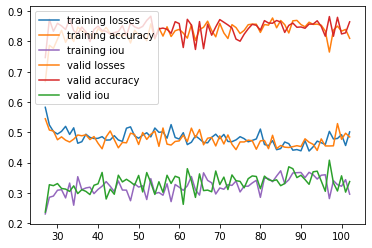

None

max valid iou: tensor(0.4079, device='cuda:0')


In [0]:
import os
from IPython.display import display
import matplotlib.pyplot as plt

max_valid_iou = 0
start = 27

epochs = []
training_losses = []
training_accuracies = []
training_ious = []
valid_losses = []
valid_accuracies = []
valid_ious = []



for i in range(start, int(EPOCHS / EPOCHS_PER_UPDATE)):
  train_validation_loop(net, optimizer, scheduler, train_loader, train_loader, EPOCHS_PER_UPDATE, i)
  epochs.append(i)
  x = epochs
  plt.plot(x, training_losses, label='training losses')
  plt.plot(x, training_accuracies, 'tab:orange', label='training accuracy')
  plt.plot(x, training_ious, 'tab:purple', label='training iou')
  plt.plot(x, valid_losses, label='valid losses')
  plt.plot(x, valid_accuracies, 'tab:red',label='valid accuracy')
  plt.plot(x, valid_ious, 'tab:green',label='valid iou')
  plt.legend(loc="upper left")

  display(plt.show())

  print("max valid iou:", max_valid_iou)



In [0]:
for i in range(500, 500+ int(EPOCHS / EPOCHS_PER_UPDATE)):
  train_validation_loop(net, optimizer, scheduler, train_loader, train_loader, EPOCHS_PER_UPDATE, i)
  epochs.append(i)
  x = epochs
  plt.plot(x, training_losses, label='training losses')
  plt.plot(x, training_accuracies, 'tab:orange', label='training accuracy')
  plt.plot(x, training_ious, 'tab:purple', label='training iou')
  plt.plot(x, valid_losses, label='valid losses')
  plt.plot(x, valid_accuracies, 'tab:red',label='valid accuracy')
  plt.plot(x, valid_ious, 'tab:green',label='valid iou')
  plt.legend(loc="upper left")

  display(plt.show())

  print("max valid iou:", max_valid_iou)


In [0]:
i, l = next(iter(valid_loader))
net_out = net(i.cuda())["out"]

In [0]:
computeIOU(net_out, l.cuda())

In [0]:
def computeAccuracy(output, target):
  output = torch.argmax(output, dim=1).flatten() 
  target = target.flatten()
  no_ignore = target.ne(255).cuda()
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  correct = torch.sum(output.eq(target))
  return correct.float() / len(target)

computeAccuracy(net_out[2].unsqueeze(0), l.cuda()[2].unsqueeze(0))

In [0]:
def computeIOU(output, target):
  output = torch.argmax(output, dim=1).flatten()
  target = target.flatten()
  no_ignore = target.ne(255).cuda()
  print(output)
  print(target)
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  print(output)
  print(target)
  intersection = torch.sum(output * target)
  union = torch.sum(target) + torch.sum(output) - intersection
  return (intersection + .0000001) / (union + .0000001)

im = Image.fromarray(np.uint8(output[0].cpu().numpy() * 255) , 'L')
computeIOU(torch.stack([net_out[3]]), torch.stack([l[3].cuda()]))

In [0]:
print(torch.argmax(torch.stack([net_out[1]]), dim=1).flatten())
c = torch.argmax(torch.stack([net_out[3]]), dim=1)
a = torch.argmax(torch.stack([net_out[1]]), dim=1).flatten()
print(a.shape)
print(l[0].flatten().shape)
pred_wat = a.eq(1)
real_wat = l[1].flatten().cuda().eq(1)
print(a.eq(1) * (l[1].flatten().cuda().eq(1)))
inter = torch.sum(pred_wat * real_wat)
union = torch.sum(pred_wat) + torch.sum(real_wat) - inter
print(torch.sum(pred_wat * real_wat))
print(torch.sum(pred_wat) + torch.sum(real_wat))
print(torch.sum(pred_wat) + torch.sum(real_wat) / ((torch.sum(pred_wat) + torch.sum(real_wat) - torch.sum(pred_wat) + torch.sum(real_wat))))
print(inter)
print(union)
iou = inter.float() / union
print(iou)
computeIOU(torch.stack([net_out[1]]).cuda(), torch.stack([l[1]]).cuda())
print(c.squeeze())
print("match", torch.sum(c.squeeze().eq(1)))
print((c.squeeze().cpu().detach().numpy() * 255))
im = Image.fromarray((c.squeeze().cpu().detach().numpy() * 255), 'L')
im

In [0]:
im = Image.fromarray((l[3].squeeze().cpu().detach().numpy() * 255), 'L')
im

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as colors
#i, l = next(iter(valid_loader))
#print(l[0])
#i = 2
plt.imshow(i[0][0])
#plt.imshow(l[0])

In [0]:
c = torch.argmax(torch.stack([net_out[2]]), dim=1)
c = c.squeeze().cpu().detach().numpy()
plt.imshow(c)

In [0]:
test_dataset[0][1].shape

In [0]:
mean = 0.
std = 0.
i = 0
total_water = 0
total_land = 0
total_mix = 0
for images, label in test_loader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    if torch.sum(images != images) != 0:
      print("NAN")
      continue
    #print(images)
    #print(images.max(2))
    #print(images.min(2))
    #print(images.mean(2))
    total_water += torch.sum(label == 1)
    total_land += torch.sum(label == 0)
    total_mix += torch.sum(label == 255)
    #print(images)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    i += len(images)

mean /= i
std /= i
mean, std, total_water, total_land, total_water.float() / (total_land + total_water.float() + total_mix), total_land.float() / (total_land + total_water.float() + total_mix)


In [74]:
def test_loop(test_data_loader, net):
  net = net.eval()
  net = net.cuda()
  count = 0
  iou = 0
  loss = 0
  accuracy = 0
  with torch.no_grad():
      for (images, labels) in tqdm(test_data_loader):
          net = net.cuda()
          outputs = net(images.cuda())
          valid_loss = criterion(outputs["out"], labels.long().cuda())
          valid_iou = computeIOU(outputs["out"], labels.cuda())
          iou += valid_iou
          accuracy += computeAccuracy(outputs["out"], labels.cuda())
          count += 1

  iou = iou / count
  print("Test IOU:", iou)
  print("Test Accuracy:", accuracy / count)

test_loop(test_loader, net)

Test IOU: tensor(0.2258, device='cuda:0')
Test Accuracy: tensor(0.8415, device='cuda:0')


In [0]:
i, l = next(iter(test_loader))

In [0]:
net = net.cuda()
outputs = net(i.cuda())["out"]


In [0]:
#print(torch.argmax(outputs, dim=1))
print(torch.argmax(outputs, dim=1).shape)
print(torch.sum(torch.argmax(outputs, dim=1)[4]))

plt.imshow(torch.argmax(outputs, dim=1)[4].cpu().detach().numpy())

In [0]:
plt.imshow(l[4].cpu().detach().numpy())

In [0]:
from PIL import Image
import os
import rasterio
import numpy as np
im = Image.fromarray(np.uint8(flood_data[4][0][1] * 255) , 'L')
print("did stuff")
im.convert("L")



In [0]:
xf, yf = processTestIm(flood_data[0])
xp, yp = valid_dataset[1]
print(xp.unsqueeze(0).shape)
transforms.ToPILImage()(net(xp.unsqueeze(0).cuda())["out"][0].cpu())

In [0]:
xp, yp = valid_dataset[1]
print(valid_data[0][1])
print(Image.fromarray(valid_data[1][0][0] * 255).convert("L").size)
Image.fromarray(valid_data[1][1][0] * 255).convert("L")

In [0]:
Image.fromarray(xp[0].cpu().numpy() * 255).convert("L")

In [0]:
#print(yp)
yp
Image.fromarray(yp.cpu().numpy() * 255).convert("L")

In [0]:
print(yp)
Image.fromarray(yp.cpu().numpy() * 255).convert("L")

In [0]:
def processAndAugment(data):
  (x,y) = data
  im,label = x.copy(), y.copy()

  # convert to PIL for easier transforms
  im1 = transforms.ToPILImage()(im[0])
  im2 = transforms.ToPILImage()(im[1])
  label = transforms.ToPILImage()(label.squeeze())

  # Get params for random transforms
  i, j, h, w = transforms.RandomCrop.get_params(im1, (256, 256))
  
  im1 = F.crop(im1, i, j, h, w)
  im2 = F.crop(im2, i, j, h, w)
  label = F.crop(label, i, j, h, w)
  if random.random() > 0.5:
    im1 = F.hflip(im1)
    im2 = F.hflip(im2)
    label = F.hflip(label)
  if random.random() > 0.5:
    im1 = F.vflip(im1)
    im2 = F.vflip(im2)
    label = F.vflip(label)
  
  norm = transforms.Normalize([0.6851, 0.5235], [0.0820, 0.1102])
  im = torch.stack([transforms.ToTensor()(im1).squeeze(), transforms.ToTensor()(im2).squeeze()])
  return im, transforms.ToTensor()(label).squeeze()


def processTestImspec(data):
  (x,y) = data
  im,label = x.copy(), y.copy()
  norm = transforms.Normalize([0.6851, 0.5235], [0.0820, 0.1102])
  im = torch.from_numpy(im)
  #im = norm(im)
  # convert to PIL for easier transforms
  im_c1 = transforms.ToPILImage()(im[0]).resize((512,512))
  im_c2 = transforms.ToPILImage()(im[1]).resize((512,512))
  label = transforms.ToPILImage()(label.squeeze())

  im_c1s = [F.crop(im_c1, 0, 0, 256, 256), F.crop(im_c1, 0, 256, 256, 256),
            F.crop(im_c1, 256, 0, 256, 256), F.crop(im_c1, 256, 256, 256, 256)]
  im_c2s = [F.crop(im_c2, 0, 0, 256, 256), F.crop(im_c2, 0, 256, 256, 256),
            F.crop(im_c2, 256, 0, 256, 256), F.crop(im_c2, 256, 256, 256, 256)]
  labels = [F.crop(label, 0, 0, 256, 256), F.crop(label, 0, 256, 256, 256),
            F.crop(label, 256, 0, 256, 256), F.crop(label, 256, 256, 256, 256)]


  ims = [torch.stack((transforms.ToTensor()(x).squeeze(),
                    transforms.ToTensor()(y).squeeze()))
                    for (x,y) in zip(im_c1s, im_c2s)]
  ims = torch.stack([norm(im) for im in ims])
  labels = [transforms.ToTensor()(label).squeeze() for label in labels]
  labels = torch.stack(labels)
  return ims[0], labels


xp, yp = processTestIm(flood_data[1])
#xp, yp = next(iter(test_loader))
print(xp.shape)
print(xp[1])
Image.fromarray(xp[1][0].cpu().numpy() * 255).convert("L")

In [0]:
Image.fromarray(yp[3].cpu().numpy() * 255).convert("L")

In [0]:
print(flood_data[1][1].shape)
Image.fromarray(flood_data[1][1][0] * 255).convert("L")

In [0]:
print(flood_data[1][1].shape)
#im2 = transforms.ToTensor()(transforms.ToPILImage()(flood_data[1][1].squeeze()))
im2 = torch.from_numpy(flood_data[1][1].squeeze())
print(im2.cpu().numpy().shape)
print(im2.cpu().numpy())
print(flood_data[1][1].shape)
print(flood_data[1][1])
print(im2.cpu().numpy().dtype)
print(flood_data[1][1].dtype)
print(im2.cpu().numpy().shape)
print(flood_data[1][1][0].shape)

print(im2.cpu().numpy().round() == flood_data[1][1][0].round())
print(np.sum((im2.cpu().numpy()[0].round() != flood_data[1][1][0].round())))
Image.fromarray(im2.cpu().numpy() * 255).convert("L")

In [0]:
next(iter(test_loader))[0].shape

In [0]:
transforms.ToPILImage()(net(xp.cuda())["out"][0].cpu())

In [0]:
im = Image.fromarray(np.uint8(train_data[0][0][0] * 255) , 'L')
print("did stuff")
im.convert("L")



In [0]:
im = Image.fromarray(np.uint8(train_data[0][1][0] * 255) , 'L')
print("did stuff")
im.convert("L")


In [0]:
test_dataset[0]

In [0]:
l.shape

In [0]:
i, l = valid_dataset[0]
print(valid_file)
im = Image.fromarray(np.uint8(l * 255) , 'L')
im

In [0]:
#im = Image.fromarray(np.uint8(i[1][1] * 255) , 'L')
print(i.numpy()[0].shape)
im = Image.fromarray(i[0][0].cpu().numpy(), 'L')
im

In [0]:
len(train_dataset)

In [0]:
a = train_data[50][0][1]
im = Image.fromarray((a * 255), "L")
im

In [0]:
def download_flood_water_data_from_list(l):
  i= 0
  tot_nan = 0
  tot_good = 0
  flood_data = []
  for (im_fname, mask_fname) in l:
    arr_x = getArrFlood(os.path.join("/content/files4/S1", im_fname))
    print(os.path.join("/content/files4/QC_v2", mask_fname))
    arr_y = np.uint8(getArrFlood(os.path.join("/content/files4/QC_v2", mask_fname)))
    tot_nan += np.sum(arr_x != arr_x)
    tot_good += np.sum(arr_x == arr_x)
    if np.sum((arr_x != arr_x)) == 0:
      ignore = np.uint8((arr_y == -1))
      ignore = np.uint8(((np.uint8(ignore) * -1) * 256) + 1)
      arr_y *= ignore
      arr_x = np.clip(arr_x, -50, 1)
      arr_x = (arr_x + 50) / 51
      i += 1
      flood_data.append((arr_x,arr_y))
      print(i)
    else:
      print("skipping nan")
  print(tot_nan, tot_good)
  return flood_data


In [0]:
arr_x = getArrFlood(os.path.join("/content/files4/S1", "India_179238_S1.tif"))
arr_x

In [0]:
arr_x = np.clip(arr_x, -50, 1)
arr_x = (arr_x + 50) / 51
print(arr_x)
Image.fromarray(arr_x[0] * 255, "L")